Checking the accuracy of the algorithmic tracking

In [7]:
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt

In [8]:
# Load data

# Load data from algorithmic tracking
raterFiles = glob.glob("data/P*.txt")
df_algoFiles = (pd.read_csv(f, header = None) for f in raterFiles)
df_algo   = pd.concat(df_algoFiles, ignore_index=True, axis = 0)

# Load data from manual ratings
raterFiles = glob.glob("data/data_Rater*.csv")
df_raterFiles = (pd.read_csv(f, header = 0) for f in raterFiles)
df_rater   = pd.concat(df_raterFiles, ignore_index=True)

In [9]:
# Prepare data

# Only take the last judgement of each rater
df_rater.drop_duplicates(subset=['Rater', 'Frame', 'Trial'], keep='last', inplace = True)

# Rename columns
df_algo.columns = ["Trial", "AOI", "1", "2", "3", "4", "5", "6", "VisiblePoints", "7", "8" ]

# Add frame number column
df_algo["Frame"] = df_algo.groupby(['Trial']).cumcount()
# df_rater["Frame_guess"] = df_rater.groupby(['Trial', 'Rater']).cumcount()

# Set datatypes
df_algo["Trial"] = df_algo["Trial"].astype("string")
df_algo["Frame"] = df_algo["Frame"].astype("string")
df_algo["AOI"] = df_algo["AOI"].astype("string")
df_rater["Frame"] = df_rater["Frame"].astype("string")
df_rater["Trial"] = df_rater["Trial"].astype("string")
df_rater["Label"] = df_rater["Label"].astype("string")


In [10]:
# Rename the labels to match the AOI from the algorithmic approach
df_algo['AOI'] = df_algo['AOI'].str.replace("Nose","Head")
df_algo['AOI'] = df_algo['AOI'].str.replace("Neck","Chest")
df_algo['AOI'] = df_algo['AOI'].str.replace("LElbow","Left arm")
df_algo['AOI'] = df_algo['AOI'].str.replace("RElbow","Right arm")
df_algo['AOI'] = df_algo['AOI'].str.replace("RKnee","Right leg")
df_algo['AOI'] = df_algo['AOI'].str.replace("LKnee","Left leg")
df_algo['AOI'] = df_algo['AOI'].str.replace("MidHip","Pelvis")

# Check the unique values
df_algo['AOI'].unique()


<StringArray>
[     'Head',     'Other',     'Chest', 'Right leg',  'Left leg',  'Left arm',
 'Right arm',    'Pelvis']
Length: 8, dtype: string

In [18]:
# Merge data frames
# df = pd.concat([df_rater, df_algo], ignore_index=True)

# merge on trial and frame
df = pd.merge(df_algo, df_rater, how = 'inner', on = ["Trial", "Frame"])



In [21]:
# Get percentage of correctly identified frames
df['Correct'] = df.AOI == df.Label

# Only keep interesting columns
df.drop(columns=["1", "2", "3", "4", "5", "6", "7", "8", "CurrentIndex"], inplace = True)

# Subset the other column (Others are not relevant)
df = df[df.AOI != "Other"]
df = df[df.Label != "Other"]

df_rater1 = df[df.Rater == "Rater1"]
df_rater2 = df[df.Rater == "Rater2"]

# Total correct
print(df.Correct.sum() / len(df.Correct))

# Rater 1 correct
print(df_rater1.Correct.sum() / len(df_rater1.Correct))
print(df_rater2.Correct.sum() / len(df_rater2.Correct))


0.7902648532569793
0.8646723646723646
0.7151079136690648


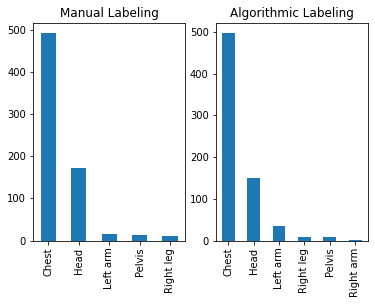

In [185]:
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2)

df['Label'].value_counts().plot(kind = 'bar', ax = axes[0])
df['AOI'].value_counts().plot(kind = 'bar', ax = axes[1])

axes[0].set_title("Manual Labeling")
axes[1].set_title("Algorithmic Labeling")

plt.savefig("Validation_Daniel.png", bbox_inches='tight')